# Importing Modules and Data

In [1]:
from learntools import Network, Learning
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
#https://www.ajbell.co.uk/market-research/sub/FUND:BJS8SJ3/charts-performance

899 886 799


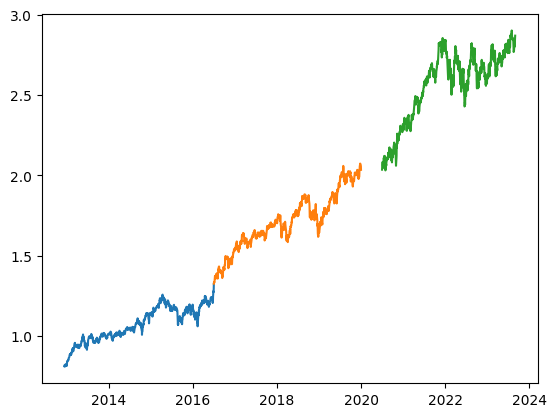

In [2]:
fidelityDF = pd.read_csv('Fidelity Index World P Acc.csv')
fidelityDF.drop(["Date","NAV"], axis = 1, inplace = True)
fidelityDF.rename(columns = {"Name": "Open"}, inplace = True)
fidelityDF.index = pd.to_datetime(fidelityDF.index)

# we exclude the huge drop at covid
preCovid1 = fidelityDF[:"07-01-2016"]
preCovid2 = fidelityDF["07-01-2016":"01-01-2020"]
postCovid = fidelityDF["07-01-2020":]
print(len(preCovid1), len(preCovid2), len(postCovid))
split_data = [preCovid1,preCovid2,postCovid]
split_dates = [list(range(len(data))) for data in split_data]
for data in split_data:
    plt.plot(data["Open"])

# Defining the Broker and Relevant Functions

In [3]:
class broker:
    def __init__(self,data,dates,func):
        self.cash = 0 # starts with 1.0 cash
        self.indexSum = 1
        self.dateIndex = 0 
        self.dates = dates
        self.data = data / data[0] # index is normalised to 1.0 start
        self.maxDate = len(data)
        self.func = func

        self.totalValue = np.zeros(len(data))
        self.indexValue = np.zeros(len(data))
        self.cashValue = np.zeros(len(data))
        
        
        if len(data) != len(dates):
            print('Error: data length does not match date length')
            
    def buy(self,value: float):
        if value > self.cash:
            value = self.cash
            #print('Warning Buy Cash greater than amount held. DateIndex/Date=',self.dateIndex,self.dates[self.dateIndex])
        
        self.cash = self.cash - value
        self.indexSum = self.indexSum + value/self.data[self.dateIndex]
        
        
    def sell(self,value: float):
        if value > self.indexSum:
            value = self.indexSum
            #print('Warning Sell Value greater than amount held. DateIndex/Date=',self.dateIndex,self.dates[self.dateIndex])
        
        self.indexSum = self.indexSum - value
        self.cash = self.cash + value*self.data[self.dateIndex]
            
    def makeMove(self):
        seenData = self.data[:self.dateIndex+1] #if dateIndex is 0 it is first day
        seenDates = self.dates[:self.dateIndex+1]

        # function here using seen data that returns a number between 0 and 1
        # 1 being all value in cash, 0 being all value in stock
        action = self.func(seenData,seenDates) # add function here
        
        if action == -1: #pass
            pass
        else:

            currentValue = self.cash + self.indexSum * self.data[self.dateIndex] # current value of portfolio
            wantedValue = action * currentValue # wanted value in cash

            if self.cash > wantedValue: #if we have more cash than wanted
                #buy
                cashValue = self.cash-wantedValue
                self.buy(cashValue)

            elif self.cash < wantedValue: #if we have less cash than wanted
                #sell
                cashValue = wantedValue - self.cash
                indexValue = cashValue/self.data[self.dateIndex]
                self.sell(indexValue)

        self.indexValue[self.dateIndex] = self.indexSum
        self.cashValue[self.dateIndex] = self.cash
        self.totalValue[self.dateIndex] = self.cash + self.indexSum * self.data[self.dateIndex]
        self.dateIndex += 1 # after move is made, move to next date
        
    def run(self):
        for i in range(self.maxDate-self.dateIndex):
            self.makeMove()
            
    def plot(self,dataName: str):
        ax = plt.gca()
        plotDF = pd.DataFrame()
        plotDF['Dates'] = self.dates
        plotDF['Index'] = self.data
        plotDF['Trader'] = self.totalValue
        
        plotDF.plot(x='Dates',y='Trader',ax=ax)
        plotDF.plot(x='Dates',y='Index',ax=ax,label=dataName)
        plt.xticks(rotation=90)
        '''
        plt.plot(self.dates,self.data,label = dataName)
        plt.plot(self.dates,self.totalValue,label = 'Trader')
        
        plt.title(dataName+' vs Trader Performance')
        plt.legend()
        '''

def linearMemoryDiff(seenData,seenDates,memory=0):
    '''
    function to fit a linear regression to 
    memory number of datapoints back
    then take the difference of the 
    predicted vs actual value
    '''
    if memory == 0:
        return 0
    else:
        seenData = seenData[-memory:]
        seenDates = seenDates[-memory:]
    
    x = np.arange(0, len(seenData))
    y = seenData
    
    coeffs = np.polyfit(x, y, 1)
    fit = np.poly1d(coeffs)
    
    predictedValue = fit(x[-1])

    return seenData[-1]/predictedValue - 1



# Data Preprocessing

In [4]:
# creating Input Data from varing linear regression sizes
memory_lengths = [10,20,40,60,100,150,200,300,400,500,600,700,1000]

input_matricies = [np.zeros((len(data),len(memory_lengths))) for data in split_data]

for k, data in enumerate(split_data):
    for i in range(2,len(data)): # need 2 points to linearly interpolate
        seenData = data.iloc[:i]["Open"]
        seenDates = split_dates[k][:i]
        for j,m in enumerate(memory_lengths):
            input_matricies[k][i][j] = linearMemoryDiff(seenData,seenDates,m)

input_matricies[0].shape

C:\Users\wwden\AppData\Local\Temp\ipykernel_11020\3786633282.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return seenData[-1]/predictedValue - 1


(899, 13)

# Training

In [52]:
# build function to output trained network for each data set
net = Network.network(len(memory_lengths),1)
net.add_layer(Network.layer_dense(len(memory_lengths),1))
net.add_layer(Network.sigmoid())

def trainNet(net,index,input_matricies):
    prices = split_data[index]["Open"].to_numpy()
    dates = np.array(split_dates[index])
    assert prices.shape == dates.shape


    def loss_func(net):
        bot = lambda seenData,seenDates: net.forward([input_matricies[index][len(seenData)-1]])[0][0]
        FID = broker(prices,dates,bot)
        FID.dateIndex = 200
        FID.run()
        return 1/FID.totalValue[-1]

    loss,data = Learning.random_learning(net,loss_func,step = 1,max_mutations=100, info = True)

    return loss,data

def run(net,index,input_matricies):
    prices = split_data[index]["Open"].to_numpy()
    dates = np.array(split_dates[index])
    bot = lambda seenData,seenDates: net.forward([input_matricies[index][len(seenData)-1]])[0][0]
    FID = broker(prices,dates,bot)
    FID.dateIndex = 200
    FID.run()

    return FID

In [8]:
# generating a net for each dataset
from copy import deepcopy
ex_net = Network.network(len(memory_lengths),1)
ex_net.add_layer(Network.layer_dense(len(memory_lengths),1))
ex_net.add_layer(Network.sigmoid())

nets = [deepcopy(ex_net) for _ in split_data]

Iter 0 Loss 0.7100678338118888
Iter 1 Loss 0.6449686937574995
Iter 2 Loss 0.6257670730786977
Iter 3 Loss 0.614429125065509
Iter 4 Loss 0.6136366187886652
Iter 5 Loss 0.6128417418722004
Iter 6 Loss 0.6127982392348226
Iter 7 Loss 0.6126744415963168
Iter 8 Loss 0.6126742027111379
Iter 9 Loss 0.6126606461847975
Iter 10 Loss 0.6126548044029495
Iter 11 Loss 0.6126517725441651
Iter 12 Loss 0.6126445808951917
Iter 13 Loss 0.6126440627917092
Iter 14 Loss 0.6126436645720111
Iter 15 Loss 0.6126435976153869
Iter 16 Loss 0.6126434128552668
Iter 17 Loss 0.6126432629308658
Iter 18 Loss 0.6126432499853657
Iter 19 Loss 0.6126432447115807
Iter 20 Loss 0.6126432443561876
Iter 21 Loss 0.6126432440470272
Iter 22 Loss 0.612643228975981
Iter 23 Loss 0.6126432197318185
Iter 24 Loss 0.6126432115488043
Iter 25 Loss 0.6126432105515701
Iter 26 Loss 0.6126431404126731
Iter 27 Loss 0.6126426824052612
Iter 28 Loss 0.6126426729828721
Iter 29 Loss 0.6126412743118361
Iter 30 Loss 0.6126409659801485
Iter 31 Loss 0.61264

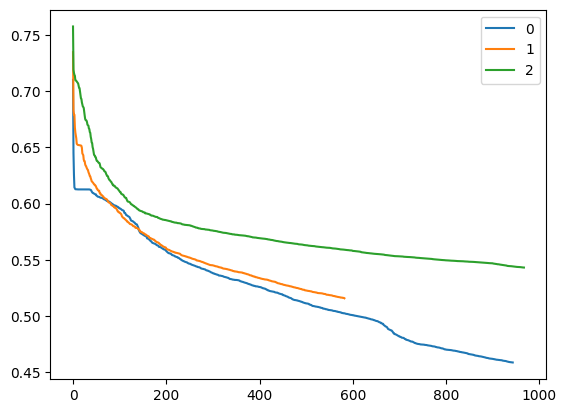

In [9]:
#training took around 10-20 minutes
for i,net in enumerate(nets):
    loss,data = trainNet(net,i,input_matricies)
    plt.plot(loss,label = str(i))
    print(i,"=================")
    print(net)

plt.legend()

# Saving

In [11]:
for i,net in enumerate(nets):
    net.save_to_file(f"net{i}.pkl")
    print(net)


---------- 
layer_dense
Weights: 
[[ 266.90637955]
 [ 159.88067202]
 [ -69.40314597]
 [-207.26273096]
 [ 268.55314262]
 [  26.85648598]
 [  32.42066871]
 [ -57.67116956]
 [-227.65203028]
 [-207.30331875]
 [ 197.95777091]
 [ 104.65221549]
 [ 263.53220895]]
Biases: 
[-0.47385909]
---------- 
sigmoid
function
---------- 


---------- 
layer_dense
Weights: 
[[ 232.96702069]
 [ 165.49581454]
 [ 135.24238624]
 [  85.88921905]
 [ -37.95171275]
 [  47.05519381]
 [-192.92219516]
 [ 118.15918617]
 [ -56.49442015]
 [  25.84758651]
 [ -95.73675967]
 [  42.83231967]
 [ 205.28414039]]
Biases: 
[-1.52614616]
---------- 
sigmoid
function
---------- 


---------- 
layer_dense
Weights: 
[[-221.29468389]
 [ -97.08889861]
 [ -77.40436652]
 [ 295.14317793]
 [ 187.64661152]
 [  -3.64308054]
 [ 306.50509102]
 [ 392.31823018]
 [ 191.09122088]
 [ 187.22015448]
 [  79.64809185]
 [  51.43889613]
 [  75.35734288]]
Biases: 
[-13.4299242]
---------- 
sigmoid
function
---------- 



# Loading 

In [102]:
nets = []
def step(x):
    return (np.sign(x) + 1) / 2

for i in range(3):
    net = Network.load_network_from_file(f"net{i}.pkl")
    net.remove_layer(1)
    net.add_layer(Network.activation_function(step))
    nets.append(net)

# Weights analysis

Cosine between net0 and net1: 0.28004837725993525
Cosine between net0 and net2: -0.28125971414418327
Cosine between net1 and net2: -0.2032987976777475


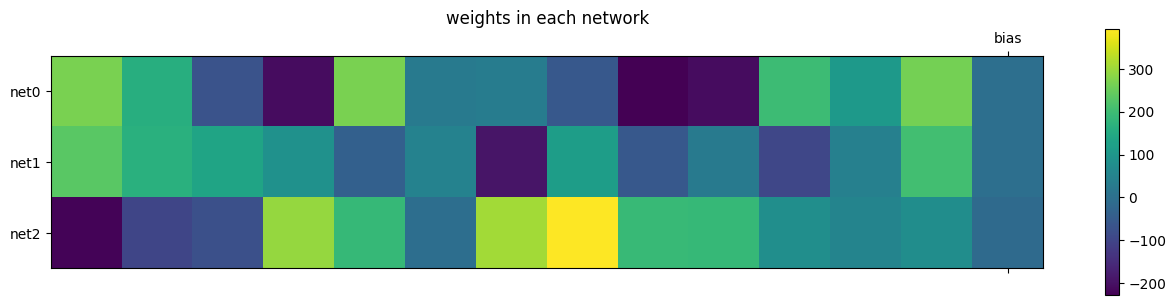

In [103]:
show_weights = np.zeros((3,14))
for i,net in enumerate(nets):
    show_weights[i][:13] = (net.layers[0].weights).reshape((13))
    show_weights[i][-1] = net.layers[0].biases[0]

plt.matshow(show_weights)
plt.yticks([0,1,2],['net0', 'net1', 'net2'])
plt.xticks([13],['bias'])
plt.title("weights in each network")
plt.colorbar()

# -1 dissimilar to 1 perfectly similar
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)

    return similarity

# this can perhaps describle market conditions, especially after models are more refined
print(f"Cosine between net0 and net1: {cosine_similarity(show_weights[0],show_weights[1])}")
print(f"Cosine between net0 and net2: {cosine_similarity(show_weights[0],show_weights[2])}")
print(f"Cosine between net1 and net2: {cosine_similarity(show_weights[1],show_weights[2])}")


# Performance

In [104]:
performance = pd.DataFrame()
performance["Training_DataSet"] = [0,1,2]
performance["Data0"] = [run(nets[i],0,input_matricies) for i in range(3)]
performance["Data1"] = [run(nets[i],1,input_matricies) for i in range(3)]
performance["Data2"] = [run(nets[i],2,input_matricies) for i in range(3)]

In [105]:
performance

,Training_DataSet,Data0,Data1,Data2
0,0,<__main__.broker object at 0x000002688D9EDB10>,<__main__.broker object at 0x000002688D847F50>,<__main__.broker object at 0x000002688EFDFB10>
1,1,<__main__.broker object at 0x000002688D83BDD0>,<__main__.broker object at 0x000002688EFC7E10>,<__main__.broker object at 0x000002688EF5ABD0>
2,2,<__main__.broker object at 0x000002688EF806D0>,<__main__.broker object at 0x000002688DA4A0D0>,<__main__.broker object at 0x000002688D79D790>


index: 1.6322713232670039
net0: 0.6999743408670611
net1: -0.16466417390597665
net2: -0.07625276305892492


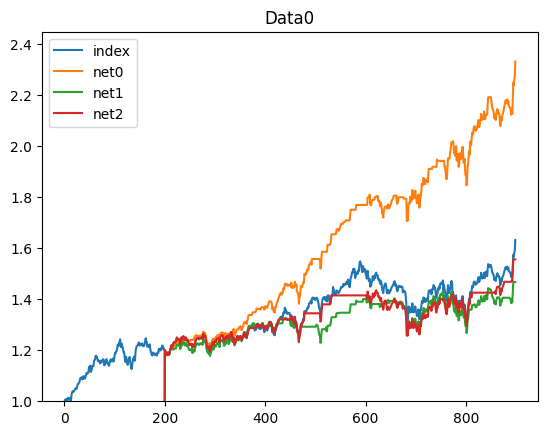

In [106]:
# On DataSet 0
col = performance["Data0"]
plt.title("Data0")
plt.plot(col[0].data, label='index')
print(f"index: {col[0].data[-1]}")
for i in range(3):
    plt.plot(col[i].totalValue, label = f"net{i}")
    print(f"net{i}: {col[i].totalValue[-1] - col[0].data[-1]}")
plt.ylim(1)
plt.legend()


index: 1.5339264173703258
net0: 0.13600045972831154
net1: 0.4931851099395519
net2: 0.07301493686548266


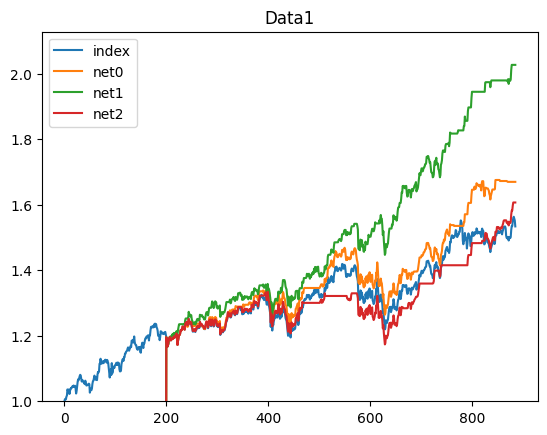

In [107]:
# On DataSet 1
col = performance["Data1"]
plt.title("Data1")
plt.plot(col[0].data, label='index')
print(f"index: {col[0].data[-1]}")
for i in range(3):
    plt.plot(col[i].totalValue, label = f"net{i}")
    print(f"net{i}: {col[i].totalValue[-1] - col[0].data[-1]}")
plt.ylim(1)
plt.legend()

index: 1.4095598349381018
net0: 0.10445205457056517
net1: 0.09028834051795864
net2: 0.4971864685511478


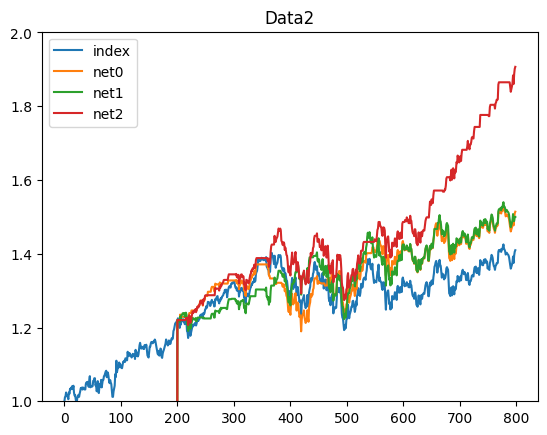

In [108]:
# On DataSet 1
col = performance["Data2"]
plt.title("Data2")
plt.plot(col[0].data, label='index')
print(f"index: {col[0].data[-1]}")
for i in range(3):
    plt.plot(col[i].totalValue, label = f"net{i}")
    print(f"net{i}: {col[i].totalValue[-1] - col[0].data[-1]}")
plt.ylim(1)
plt.legend()

-1